Saving catimg.jpg to catimg.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Top Prediction: ('n02124075', 'Egyptian_cat', np.float32(0.45228863))


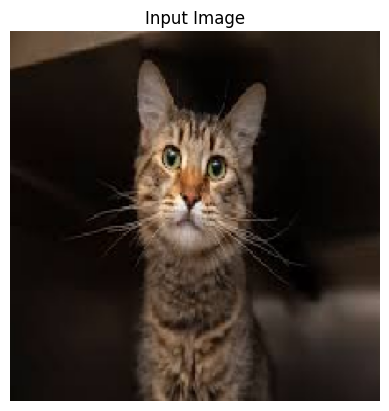

In [3]:
from google.colab import files
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, decode_predictions, preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Upload an image
uploaded = files.upload()

# Load MobileNet model
model = MobileNetV2(weights='imagenet')

# Get uploaded file name
file_name = list(uploaded.keys())[0]

# Load and preprocess image
img = image.load_img(file_name, target_size=(224, 224))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_batch)

# Predict
preds = model.predict(img_preprocessed)
print("Top Prediction:", decode_predictions(preds, top=1)[0][0])

# Show image
plt.imshow(img)
plt.axis('off')
plt.title("Input Image")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Original Image ➜ Prediction: Egyptian_cat (47.32%)


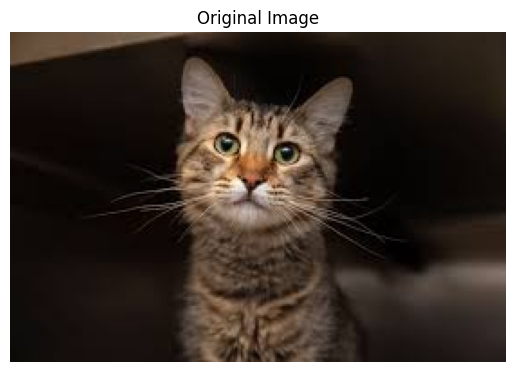

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Rotated Image ➜ Prediction: Egyptian_cat (26.54%)


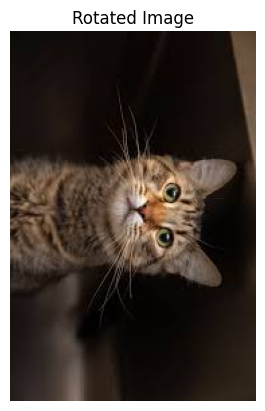

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Brightened Image ➜ Prediction: Egyptian_cat (44.81%)


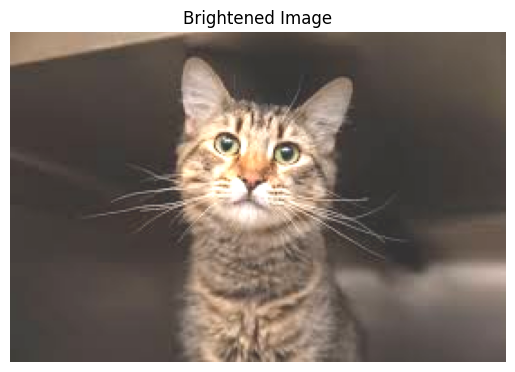

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Noisy Image ➜ Prediction: tabby (24.84%)


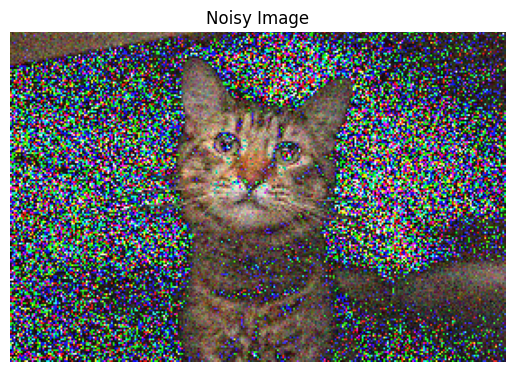

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Blurred Image ➜ Prediction: Egyptian_cat (60.17%)


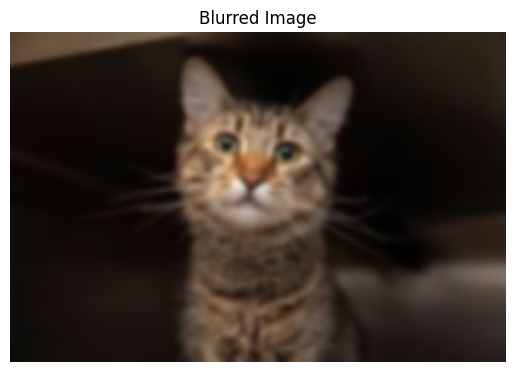

In [4]:
import cv2

# Function to preprocess image for prediction
def preprocess(img):
    img_resized = cv2.resize(img, (224, 224))
    img_array = image.img_to_array(img_resized)
    img_batch = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_batch)

# Read original image using OpenCV
img_cv = cv2.imread(file_name)
img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

# 1. Rotate the image
rotated = cv2.rotate(img_cv, cv2.ROTATE_90_CLOCKWISE)

# 2. Brightness adjustment
bright = cv2.convertScaleAbs(img_cv, alpha=1.2, beta=50)

# 3. Gaussian noise
noise = img_cv + np.random.normal(loc=0, scale=25, size=img_cv.shape).astype(np.uint8)

# 4. Blur
blurred = cv2.GaussianBlur(img_cv, (7, 7), 0)

# Dictionary to store variations
variations = {
    "Original": img_cv,
    "Rotated": rotated,
    "Brightened": bright,
    "Noisy": noise,
    "Blurred": blurred,
}

# Run prediction on each variation
for name, variant in variations.items():
    img_pre = preprocess(variant)
    pred = model.predict(img_pre)
    decoded = decode_predictions(pred, top=1)[0][0]
    print(f"{name} Image ➜ Prediction: {decoded[1]} ({decoded[2]*100:.2f}%)")

    # Display image
    plt.imshow(variant)
    plt.title(f"{name} Image")
    plt.axis('off')
    plt.show()


In [5]:
pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 91.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.3 MB/s eta 0:00:00


In [12]:
import os
import csv
import time
import psutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
import gradio as gr

# Load MobileNetV2 model
model = MobileNetV2(weights='imagenet')

# Define a function to measure inference time, memory usage, and log the results
def log_performance_metrics(img):
    # Record memory usage before processing
    process = psutil.Process()
    memory_before = process.memory_info().rss / (1024 * 1024)  # Memory in MB

    # Measure inference time
    start_time = time.time()

    # Preprocess the uploaded image
    img = img.resize((224, 224))  # Resize to MobileNetV2's expected input size
    img_array = np.array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_batch)

    # Perform prediction
    preds = model.predict(img_preprocessed)
    decoded_preds = decode_predictions(preds, top=1)[0][0]

    # Measure time taken
    inference_time = time.time() - start_time

    # Record memory usage after processing
    memory_after = process.memory_info().rss / (1024 * 1024)  # Memory in MB
    memory_usage = memory_after - memory_before

    # Ensure memory usage isn't negative (due to small discrepancies in measurement)
    memory_usage = max(0, memory_usage)

    # Prepare result
    prediction_result = f"Prediction: {decoded_preds[1]} with {decoded_preds[2]*100:.2f}% confidence"
    performance_metrics = f"Inference Time: {inference_time:.4f} seconds\nMemory Usage: {memory_usage:.2f} MB"

    # Log metrics to a CSV file
    log_data = [decoded_preds[1], decoded_preds[2]*100, inference_time, memory_usage]
    log_to_csv(log_data)

    return f"{prediction_result}\n{performance_metrics}"

# Function to log data to CSV
def log_to_csv(data):
    log_file = '/content/performance_log.csv'  # Save to Colab's persistent storage

    # Check if the file exists, if not create it and add headers
    file_exists = os.path.isfile(log_file)

    # Open the file and append data
    with open(log_file, mode='a', newline='') as file:
        writer = csv.writer(file)

        # Write headers if the file is new
        if not file_exists:
            writer.writerow(['Prediction', 'Confidence (%)', 'Inference Time (s)', 'Memory Usage (MB)'])

        # Write the data row
        writer.writerow(data)

# Create a Gradio interface
iface = gr.Interface(fn=log_performance_metrics, inputs=gr.Image(type='pil'), outputs="text")

# Launch the interface
iface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://271d44fb0f69595fe4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [16]:
# Load the performance log
log_file = '/content/performance_log.csv'
df = pd.read_csv(log_file)

# Display the first few entries
print(df.head())


         Prediction  Confidence (%)  Inference Time (s)  Memory Usage (MB)
0  golden_retriever        92.34504            2.641738         -25.289062
1  golden_retriever        92.34504            1.610052           0.000000
2          lab_coat        69.68611            0.234533          19.304688
3          lab_coat        69.68611            0.140484           0.605469


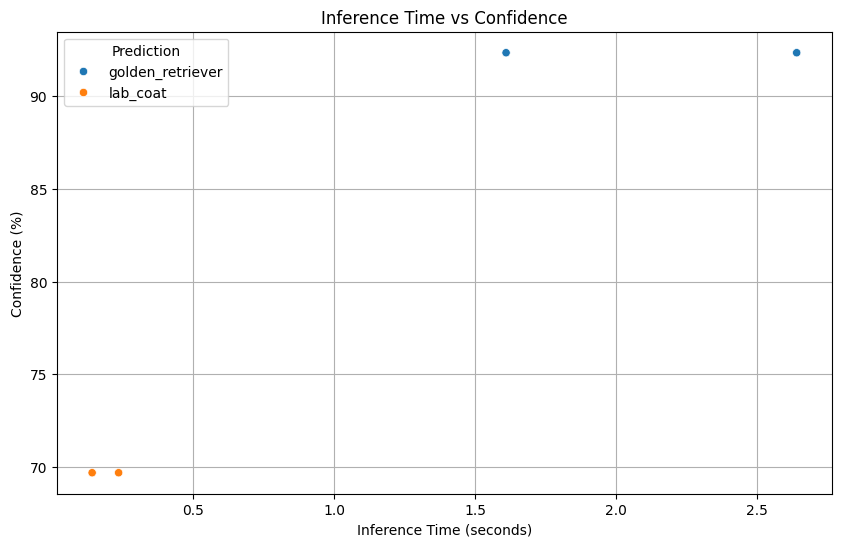

In [17]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Inference Time (s)', y='Confidence (%)', hue='Prediction', palette='tab10')
plt.title('Inference Time vs Confidence')
plt.xlabel('Inference Time (seconds)')
plt.ylabel('Confidence (%)')
plt.grid(True)
plt.show()


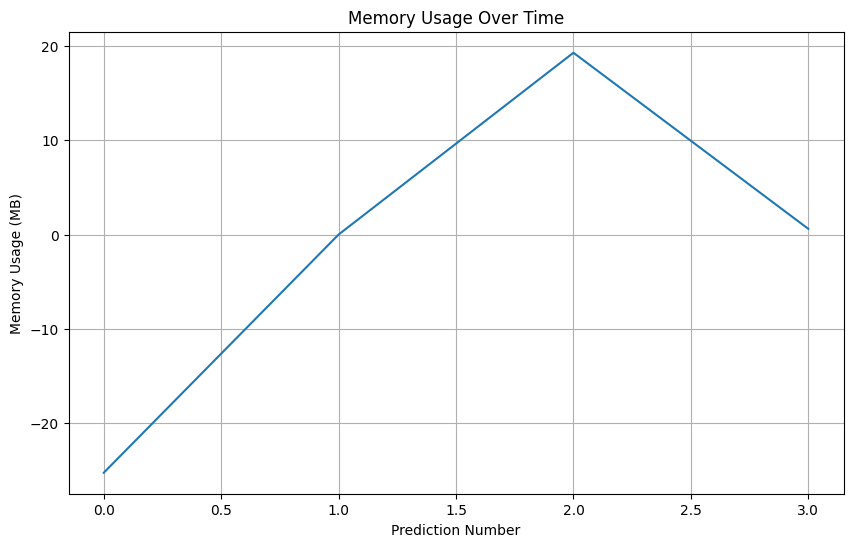

In [18]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df['Memory Usage (MB)'])
plt.title('Memory Usage Over Time')
plt.xlabel('Prediction Number')
plt.ylabel('Memory Usage (MB)')
plt.grid(True)
plt.show()


In [19]:
!pip install plotly


In [20]:
import pandas as pd
import plotly.express as px


In [21]:
df = pd.read_csv('/content/performance_log.csv')
df.head()


,Prediction,Confidence (%),Inference Time (s),Memory Usage (MB)
0,golden_retriever,92.34504,2.641738,-25.289062
1,golden_retriever,92.34504,1.610052,0.000000
2,lab_coat,69.68611,0.234533,19.304688
3,lab_coat,69.68611,0.140484,0.605469


In [22]:
fig1 = px.scatter(df,
                  x='Inference Time (s)',
                  y='Confidence (%)',
                  color='Prediction',
                  title='Inference Time vs Confidence',
                  hover_data=['Memory Usage (MB)'])
fig1.show()


In [23]:
fig2 = px.line(df,
               y='Memory Usage (MB)',
               title='Memory Usage Over Predictions',
               labels={'index': 'Prediction Number'})
fig2.show()


In [31]:
!pip install -U kaleido




In [33]:
import pandas as pd
import plotly.express as px


In [34]:
df = pd.read_csv('/content/performance_log.csv')

fig1 = px.scatter(df,
                  x='Inference Time (s)',
                  y='Confidence (%)',
                  color='Prediction',
                  title='Inference Time vs Confidence',
                  hover_data=['Memory Usage (MB)'])

fig2 = px.line(df,
               y='Memory Usage (MB)',
               title='Memory Usage Over Predictions',
               labels={'index': 'Prediction Number'})


In [36]:
!pip install -U kaleido --user


In [37]:
import pandas as pd
import plotly.express as px


In [38]:
df = pd.read_csv('/content/performance_log.csv')

fig1 = px.scatter(df,
                  x='Inference Time (s)',
                  y='Confidence (%)',
                  color='Prediction',
                  title='Inference Time vs Confidence',
                  hover_data=['Memory Usage (MB)'])

fig2 = px.line(df,
               y='Memory Usage (MB)',
               title='Memory Usage Over Predictions',
               labels={'index': 'Prediction Number'})


In [40]:
fig1.write_html("inference_vs_confidence.html")
fig2.write_html("memory_usage.html")

from google.colab import files
files.download("inference_vs_confidence.html")
files.download("memory_usage.html")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [49]:
import sqlite3
import time
import psutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
import gradio as gr
model = MobileNetV2(weights='imagenet')
def setup_database():
    conn = sqlite3.connect('/content/performance_metrics.db')  # Creates the database if it doesn't exist
    cursor = conn.cursor()
    cursor.execute('''CREATE TABLE IF NOT EXISTS performance_metrics (
                        id INTEGER PRIMARY KEY AUTOINCREMENT,
                        prediction TEXT,
                        confidence REAL,
                        inference_time REAL,
                        memory_usage REAL,
                        timestamp DATETIME DEFAULT CURRENT_TIMESTAMP
                    )''')
    conn.commit()
    conn.close()

# Call the setup function to create the database
setup_database()

# Define a function to measure inference time, memory usage, and log the results
def log_performance_metrics(img):
    # Record memory usage before processing
    process = psutil.Process()
    memory_before = process.memory_info().rss / (1024 * 1024)  # Memory in MB

    # Measure inference time
    start_time = time.time()

    # Preprocess the uploaded image
    img = img.resize((224, 224))  # Resize to MobileNetV2's expected input size
    img_array = np.array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_batch)

    # Perform prediction
    preds = model.predict(img_preprocessed)
    decoded_preds = decode_predictions(preds, top=1)[0][0]

    # Measure time taken
    inference_time = time.time() - start_time

    # Record memory usage after processing
    memory_after = process.memory_info().rss / (1024 * 1024)  # Memory in MB
    memory_usage = memory_after - memory_before

    # Ensure memory usage isn't negative (due to small discrepancies in measurement)
    memory_usage = max(0, memory_usage)

    # Prepare result
    prediction_result = f"Prediction: {decoded_preds[1]} with {decoded_preds[2]*100:.2f}% confidence"
    performance_metrics = f"Inference Time: {inference_time:.4f} seconds\nMemory Usage: {memory_usage:.2f} MB"

    # Log metrics to the SQLite database
    log_to_sql(decoded_preds[1], decoded_preds[2]*100, inference_time, memory_usage)

    return f"{prediction_result}\n{performance_metrics}"

# Function to log data to SQLite
def log_to_sql(prediction, confidence, inference_time, memory_usage):
    # Connect to the SQLite database
    conn = sqlite3.connect('/content/performance_metrics.db')
    cursor = conn.cursor()

    # Insert data into the performance_metrics table
    cursor.execute('''INSERT INTO performance_metrics (prediction, confidence, inference_time, memory_usage)
                      VALUES (?, ?, ?, ?)''', (prediction, confidence, inference_time, memory_usage))

    # Commit changes and close the connection
    conn.commit()
    conn.close()

# Create a Gradio interface
iface = gr.Interface(fn=log_performance_metrics, inputs=gr.Image(type='pil'), outputs="text")

# Launch the interface
iface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d663a876446847f310.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
